In [188]:
train_ratio = 0.85
n_epochs = 100
horizon_pred = 1

# Based on handsome-fowl-455, exp_id = 568627020038917680, run_id = 5f37223d6e9b47018cadd5978d06ec9b, tag = {group:bests}, 
params = {
    'seq_length' : [20],
    'batch_size' : [10],
    'units1' : [130],
    'activation1' : ['relu'], 
    'kernel_reg_factor1' : [0.001],
    'dropout_layer1' : [0.05],
    'dense_mid_size' : [80],
    'activation_out' : ['relu'],
    'optim' : ['nadam'],
    'company_inputs' : [['PETR4.SA']],
}

company_output = 'PETR4.SA'
end_date = '2024-10-30' 
start_date = '2020-01-01'
stock_var = 'Adj Close'

In [189]:
seq_length = params['seq_length'][0]
batch_size = params['batch_size'][0]
units1 = params['units1'][0]
activation1 = params['activation1'][0]
kernel_reg_factor1 = params['kernel_reg_factor1'][0]
dropout_layer1 = params['dropout_layer1'][0]
dense_mid_size = params['dense_mid_size'][0]
activation_out = params['activation_out'][0]
optim = params['optim'][0]
company_inputs = params['company_inputs'][0]


In [190]:
print(seq_length)
print(batch_size)
print(units1)
print(activation1)
print(kernel_reg_factor1)
print(dropout_layer1)
print(dense_mid_size)
print(activation_out)
print(optim)
print(company_inputs)

20
10
130
relu
0.001
0.05
80
relu
nadam
['PETR4.SA']


In [ ]:
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

In [ ]:
from src.feature_engineering import get_finance_df
from src.feature_engineering import split_train_test_valid_df, get_xx_dropna

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

df = get_finance_df(company_inputs, start_date, end_date, stock_var)

n_inputs = len(company_inputs)    

df_train, df_test = split_train_test_valid_df(df=df, 
    horizon_pred=horizon_pred, seq_length=seq_length, 
    size_train_percent=train_ratio, create_valid_df=False
)

X_train, y_train = get_xx_dropna(df_train, company_inputs)
X_test, y_test = get_xx_dropna(df_test, company_inputs)

# Normalize the Price column
scaler = MinMaxScaler()

scaled_X_train = scaler.fit_transform(X_train, y_train)
scaled_y_train = scaler.transform(y_train.reshape(-1, 1))

scaled_X_test = scaler.transform(X_test)
scaled_y_test = scaler.transform(y_test.reshape(-1, 1))

# Initialize generator with multivariable input and single target
generator_train = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=seq_length, batch_size=batch_size)
generator_test = TimeseriesGenerator(scaled_X_test, scaled_y_test, length=seq_length, batch_size=batch_size)

[*********************100%***********************]  1 of 1 completed


In [192]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input
from tensorflow.keras.regularizers import l2


model = Sequential()
model.add(Input((seq_length, n_inputs)))
model.add(LSTM(units=units1, activation=activation1, kernel_regularizer=l2(kernel_reg_factor1)))
if dropout_layer1 is not None:
    model.add(Dropout(rate=dropout_layer1))
if dense_mid_size is not None:
    model.add(Dense(dense_mid_size, activation=activation_out))
model.add(Dense(1, activation=activation_out))
model.compile(optimizer=optim, loss='mse')

hist = model.fit(generator_train, epochs=n_epochs, validation_data=generator_test)

c:\GitRepos\TC4-Thales\tech_challenge_4\training_model\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0342 - val_loss: 0.0021
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0011 - val_loss: 0.0078
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 8/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.6518e-04 - val_loss: 0.0095
Epoch 9/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 10/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 11/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.0331e-04 - val_loss: 0.0011
Epoch 12/100
101/101 ━

In [193]:
import numpy as np

# def make_predictions(generator, scaled_X):
y_pred = []
y_valid = []
for k in range(len(generator_test)):
    print(k)
    X_scaled_temp, y_scaled_temp = generator_test[k]
    X_scaled_temp = X_scaled_temp.reshape(len(X_scaled_temp),seq_length)
    y_pred_scaled = model.predict(X_scaled_temp)
    y_pred.append(scaler.inverse_transform(y_pred_scaled.reshape(-1,1)))
    y_valid.append(scaler.inverse_transform(y_scaled_temp.reshape(-1,1)))

y_pred = np.concatenate(y_pred, axis=0 )
y_valid = np.concatenate(y_valid, axis=0 )


0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


In [ ]:
from sklearn.metrics import root_mean_squared_error, r2_score

# Calculate RMSE and R² score
rmse = root_mean_squared_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

# training_loss = np.array(model.losses).item()
training_loss = hist.history['loss']
validation_loss = hist.history['val_loss']

In [195]:
print([ f"R2={r2}", f"RMSE={rmse}", f"loss={training_loss[-1]}", f"val_loss={validation_loss[-1]}"])

['R2=0.8241635082948711', 'RMSE=0.7402838579704708', 'loss=0.0005052845808677375', 'val_loss=0.0005925219156779349']


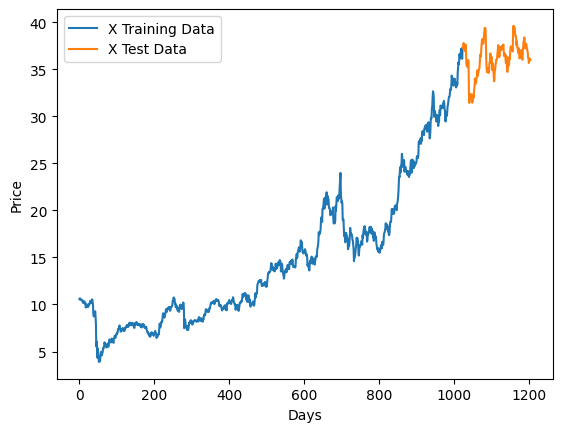

In [196]:
import matplotlib.pyplot as plt

# Plot the predicted prices\n"
N_train = len(X_train)
N_test = len(X_test)
N_valid = len(y_pred)
plt.plot(range(N_train),X_train, label="X Training Data")
plt.plot(range(N_train,N_train+N_test),X_test, label="X Test Data")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()

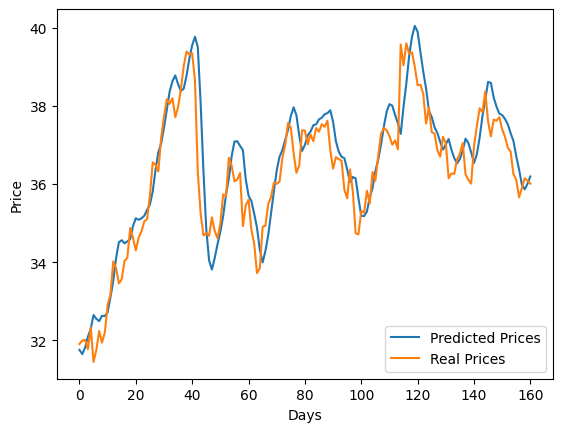

In [197]:
import matplotlib.pyplot as plt

# Plot the predicted prices\n"
plt.plot(y_pred, label="Predicted Prices")
plt.plot(y_valid, label="Real Prices")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()

In [205]:
import mlflow
import mlflow.tensorflow
import mlflow.data
import mlflow.sklearn
from mlflow.models import infer_signature
from mlflow import MlflowClient

mlflow_client = MlflowClient()

mlflow.set_tracking_uri(uri="http://127.0.0.1:7777")
mlflow.set_experiment("LSTM Champion Models")

mlflow.tensorflow.autolog()

mlflow.start_run()

# log datasets
dataset_full = mlflow.data.from_pandas(df, source="yfinance", name="df", targets=None)
mlflow.log_input(dataset_full, context="training")
dataset_train_np = mlflow.data.from_numpy(X_train, targets=y_train, name="numpy_XY_train")
mlflow.log_input(dataset_train_np, context="training")

dataset_test_np = mlflow.data.from_numpy(X_test, targets=y_test, name="numpy_XY_test")
mlflow.log_input(dataset_test_np, context="test")

# log transformer
signature_scaler = infer_signature(X_test, scaled_X_test)
try: 
    mlflow.sklearn.save_model(scaler,path="../src/artifacts/transformers/scaler", signature=signature_scaler)
except:
    print("Model already exists. If you want to overwrite a new version, retry after deleting it.")
mlflow.sklearn.log_model(scaler,artifact_path="artifacts/transformers/scaler", signature=signature_scaler)

# log parameters
X_scaled_temp, y_scaled_temp = generator_test[0]
X_scaled_temp = X_scaled_temp.reshape(len(X_scaled_temp),seq_length)
signature_model = infer_signature(X_scaled_temp, y_scaled_temp)
try:
    mlflow.sklearn.save_model(model,path="../src/artifacts/models_tf/best_models", signature=signature_model)
except:
    print("Model already exists. If you want to overwrite a new version, retry after deleting it.")
mlflow.sklearn.log_model(model,artifact_path="artifacts/models_tf/best_models", signature=signature_model)

# log parameters
mlflow.log_params(params)
mlflow.log_param("n_epochs", n_epochs)
mlflow.log_param("train_ratio", train_ratio)
mlflow.log_param("horizon_pred", horizon_pred)

# log metrics
mlflow.log_metric("R2-Score", r2)
mlflow.log_metric("RMSE", rmse)
mlflow.log_metric("final_loss", training_loss[-1])
mlflow.log_metric("final_val_loss", validation_loss[-1])


mlflow.end_run()

2024/11/23 23:00:57 WARNING mlflow.utils.autologging_utils: MLflow tensorflow autologging is known to be compatible with 2.7.4 <= tensorflow <= 2.17.0, but the installed version is 2.18.0. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a compatible version, or try upgrading MLflow.
c:\GitRepos\TC4-Thales\tech_challenge_4\training_model\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for 'yfinance'. Exception: 
  return _dataset_source_registry.resolve(
c:\GitRepos\TC4-Thales\tech_challenge_4\training_model\.venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:149: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
2024/11/23 23:00:57 